In [19]:
import geopandas as gpd
from fiona import drvsupport
drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default


In [20]:
area = gpd.read_file("data/SB 3202 Applicability Area.kml")

c:\Users\curly\miniconda3\envs\geoanalysis\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
c:\Users\curly\miniconda3\envs\geoanalysis\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
c:\Users\curly\miniconda3\envs\geoanalysis\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [21]:
# Project to NAD 1983 Albers Hawaii for area calculations https://epsg.io/102007 -- 41s
original_crs = area.crs

albers_hi = '+proj=aea +lat_0=13 +lon_0=-157 +lat_1=8 +lat_2=18 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs'
area['geometry'] = area['geometry'].to_crs(albers_hi)

<Axes: >

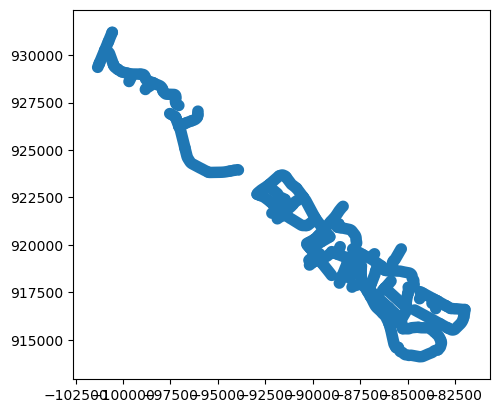

In [22]:
area.plot()

In [23]:
area.columns

Index(['Name', 'description', 'timestamp', 'begin', 'end', 'altitudeMode',
       'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'YEAR',
       'ISLAND', 'ROUTE_ID', 'BMP', 'EMP', 'ROUTE_NAME', 'COUNTY', 'COUNTY_T',
       'AADT', 'AADT_SU', 'AADT_CU', 'F_SYSTEM', 'F_SYSTEM_T', 'FAC_TYPE',
       'FAC_TYPE_T', 'MAINT_OP', 'MAINT_OP_T', 'OWNER', 'OWNER_T',
       'THROUGH_LN', 'URBAN_ID', 'URBAN_ID_T', 'Shape_Leng', 'geometry'],
      dtype='object')

In [24]:
area = area.dissolve(by='ISLAND', aggfunc='first')

In [25]:
county = gpd.read_file('./data/zoning_maps/HonoluluCountyHonoluluCountyHI-ZoningDistricts.geojson')

county = county[['Jurisdiction','Abbreviated District Name', 'Full District Name', 'Type of Zoning District',
          '1-Family Treatment', '1-Family Max. Height', '1-Family Floor to Area Ratio', '4+-Family Treatment',
          '1-Family Min. Lot', '1-Family Min. # Parking Spaces', 'Accessory Dwelling Unit (ADU) Treatment', 'geometry']]

# project to albers hi
county['geometry'] = county['geometry'].to_crs(albers_hi)

# one-hot flag for single-family
# county['single_family'] = county['Abbreviated District Name'].str.startswith("R-")
county['single_family'] = county['Abbreviated District Name'].str.match(r"^R-|RS-|RD-|RM-|RA-")

<Axes: >

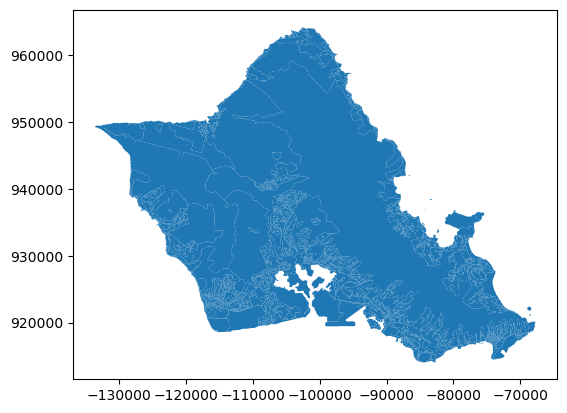

In [26]:
county.plot()

In [27]:
gdf = area.overlay(county, how='intersection')

<Axes: >

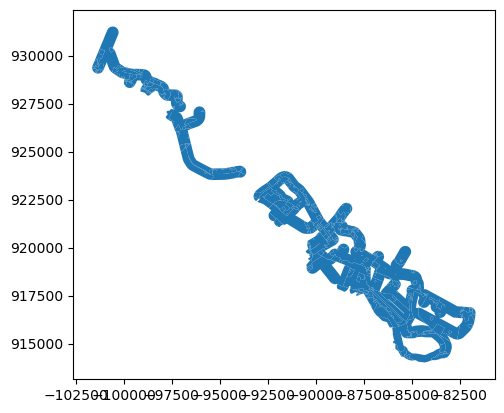

In [28]:
gdf.plot()

In [29]:
# calculate zone areas
effective_area = sum(gdf.geometry.area)

gdf['zone_area'] = gdf.geometry.area

# calculate % area for each zone
gdf['zone_pct'] = gdf['zone_area'] / effective_area

In [30]:
gdf.groupby('single_family')['zone_pct'].sum()

single_family
False    0.561044
True     0.438956
Name: zone_pct, dtype: float64

In [31]:
gdf.columns

Index(['Name', 'description', 'timestamp', 'begin', 'end', 'altitudeMode',
       'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'YEAR',
       'ROUTE_ID', 'BMP', 'EMP', 'ROUTE_NAME', 'COUNTY', 'COUNTY_T', 'AADT',
       'AADT_SU', 'AADT_CU', 'F_SYSTEM', 'F_SYSTEM_T', 'FAC_TYPE',
       'FAC_TYPE_T', 'MAINT_OP', 'MAINT_OP_T', 'OWNER', 'OWNER_T',
       'THROUGH_LN', 'URBAN_ID', 'URBAN_ID_T', 'Shape_Leng', 'Jurisdiction',
       'Abbreviated District Name', 'Full District Name',
       'Type of Zoning District', '1-Family Treatment', '1-Family Max. Height',
       '1-Family Floor to Area Ratio', '4+-Family Treatment',
       '1-Family Min. Lot', '1-Family Min. # Parking Spaces',
       'Accessory Dwelling Unit (ADU) Treatment', 'single_family', 'geometry',
       'zone_area', 'zone_pct'],
      dtype='object')

In [32]:
gdf.groupby(['1-Family Treatment', 'single_family'])['zone_pct'].sum()

1-Family Treatment   single_family
Allowed/Conditional  False            0.235052
                     True             0.438956
Prohibited           False            0.325991
Name: zone_pct, dtype: float64

<Axes: >

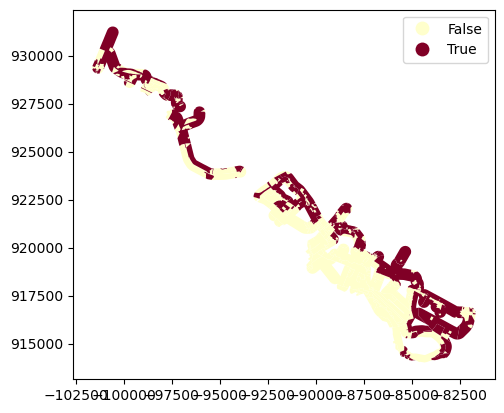

In [33]:
gdf.plot(column = 'single_family', cmap='YlOrRd', legend = True)
# for later, add bg map: https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
# solving env for contextily is hanging

In [34]:
gdf[['Abbreviated District Name', 'single_family', 'zone_pct']]

,Abbreviated District Name,single_family,zone_pct
0,A-1,False,0.024104
1,A-2,False,0.096683
2,A-3,False,0.011236
3,AG-1,False,0.001592
4,AG-2,False,0.000274
5,Aloha,False,0.002575
6,AMX-2,False,0.001517
7,AMX-3,False,0.001337
8,Apart,False,0.010300
9,ApartMix,False,0.002777


In [35]:
slud = gpd.read_file('./data/State_Land_Use_Districts.geojson')
slud['geometry'] = slud['geometry'].to_crs(albers_hi)
# filter to urban district
slud = slud[slud['lud_code'] == 1]

c:\Users\curly\miniconda3\envs\geoanalysis\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
c:\Users\curly\miniconda3\envs\geoanalysis\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [36]:
gdf2 = slud.overlay(county, how='intersection')

<Axes: >

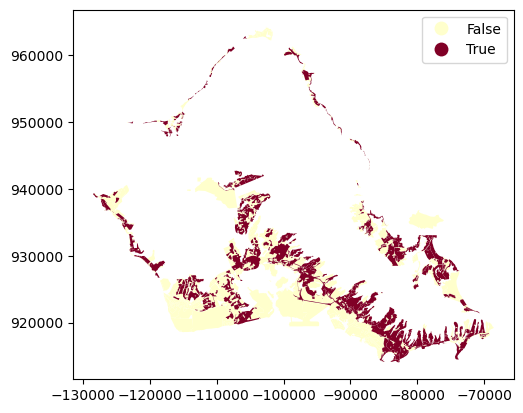

In [37]:
gdf2.plot(column = 'single_family', cmap='YlOrRd', legend = True)

In [38]:
# calculate zone areas
urban_area = sum(gdf2.geometry.area)

gdf2['zone_area'] = gdf2.geometry.area

# calculate % area for each zone
gdf2['zone_pct'] = gdf2['zone_area'] / urban_area

In [39]:
gdf2.groupby('single_family')['zone_pct'].sum()

single_family
False    0.612178
True     0.387822
Name: zone_pct, dtype: float64

In [40]:
gdf['zone_pct'][gdf['Abbreviated District Name'] == 'F-1']

14    0.037548
Name: zone_pct, dtype: float64

In [41]:
gdf2.groupby(['1-Family Treatment', 'single_family'])['zone_pct'].sum()

1-Family Treatment   single_family
Allowed/Conditional  False            0.181056
                     True             0.387822
Prohibited           False            0.431121
Name: zone_pct, dtype: float64

In [48]:
gdf2.groupby('1-Family Treatment')[['Abbreviated District Name', 'single_family', 'zone_pct']]

AttributeError: 'DataFrameGroupBy' object has no attribute 'list'

In [49]:
gdf2[['Abbreviated District Name', 'single_family', 'zone_pct']]

,Abbreviated District Name,single_family,zone_pct
0,P-1,False,1.199097e-06
1,P-2,False,6.048420e-06
2,P-1,False,4.375918e-05
3,AG-1,False,1.442427e-04
4,AG-1,False,6.874517e-07
...,...,...,...
269,P-2,False,2.140496e-02
270,R-10,True,1.893121e-02
271,R-20,True,7.870822e-04
272,R-5,True,2.864789e-02
